# Project Overview

* $\textbf{Motivation}$: The electrochemical oxygen evolution reaction (OER) is one of the most important reactions in renewable energy technology. It is an anode reaction of water splitting to produce H2 and O2, and it can be coupled with cathodic reactions such as CO2 or N2 reduction reactions to produce valuable chemicals under ambient conditions, which otherwise requires energy-intensive processes. The current challenge of water-splitting reaction is to discover better catalysts in a large chemical search space. Since water-splitting reaction is electro-chemical reaction, one of the catalyst selection criteria is to find materials that are conductive (i.e. with low bandgap). The cost of generating bandgap data and large chemical space inspired adopting accelerated computational screenings, such as machine learning. 

* $\textbf{Objective}$:The goal of this project is to develop a sequential learning procedure (SLP) that selects  materials suitable for water splitting reaction. The selection criterion would be the badgap of the materials. 

* $\textbf{Dataset}$: The dataset used in the research presented in Stein et al. Chem. Sci., 2019, 10, 47-55 https://doi.org/10.1039/C8SC03077D. 


# Load packages and files

In [1]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from monty.os import cd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

from camd.agent.base import HypothesisAgent
from camd.analysis import AnalyzerBase
from camd.experiment.base import ATFSampler
from camd.campaigns.base import Campaign

from agents_helper_scripts import get_features_from_df, BandgapAgent, explore_candidates

# 1. Preprocessing

### 1.1 Load data
Download files to SageMaker instance from S3.

In [2]:
jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

def hook(t):
    def inner(bytes_amount):
        t.update(bytes_amount)
    return inner
#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))
        
energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
print('This dataset has {} samples, {} features'.format(jcap_df.shape[0], jcap_df.shape[1]))

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:00<00:00, 163MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 22.0kB/s]


This dataset has 100430 samples, 45 features


### 1.2. Parition data into seed and candidate df

In [3]:
# random state=42 allows us to reproduce same dfs each time
seed_orig_df, candidate_orig_df = train_test_split(jcap_df, test_size=0.9, random_state=42)

# make cop of seed, candidate df so we don't modify jcap_df 
seed_df = seed_orig_df.copy()
candidate_df = candidate_orig_df.copy()

print('{} seed data, {} candidates to explore'.format(len(seed_df), len(candidate_df)))

10043 seed data, 90387 candidates to explore


### 1.3 Test various different ML algorithm and pick the best ones.
There are a lot of components one has to consider before solving a machine learning problem. Some of which includes data preparation, feature selection, feature engineering, model selection and validation, hyperparameter tuning, etc. In theory, you can find and apply a plethora of techniques for each of these components, but they all might perform differently for different datasets. The challenge is to find the best performing combination of techniques so that you can minimize the error in your predictions. 

In this step, we will outline a series of steps to choose the best machine learning model for our agent. We focused on model selection and hyperparamster tuning. If time and resources allow in thr future, these steps should be refined to intelligently explore the possible ML models to find the most suitable one for your exploration. 

In [4]:
# Helper funtion
# -------------------------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=42)
def plot_learning_curve(estimator, X, y, cv=kf, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 10), 
                        color=None, label=None):
    """
    Function that generates a learning curve. The data are split into various train sizes.
    At each train size, a 3-fold CV is used on training data, and validated on the validation data. 
    The mean and standard deviation of the CV error is plotted. 
    
    Args:
        estimator        ML model
        X                list of features
        y                list of labels      

    """
    t0 = time.time()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    plthandle, = plt.plot(train_sizes*1.5, test_scores_mean, 'o-', color=color,
             label=label,ms=15)
    plt.fill_between(train_sizes*1.5, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=plthandle.get_color())
    print('Total time', time.time()-t0) 

#### 1.3.1 ML Model selection

Total time 1.0221712589263916
Total time 3.2699573040008545
Total time 1.4162847995758057


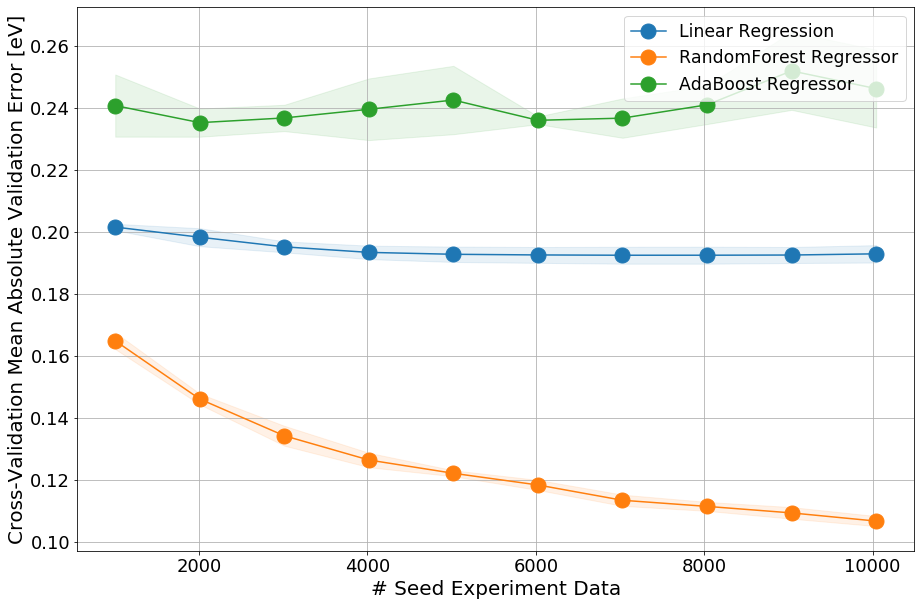

In [5]:
# we chose linear regression, random forest regressor, and adaboost regressor. 
# Each model used sklearn default hyparparamaters for a baseline comparison
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
ada = AdaBoostRegressor()

# Process Data
seed_features = get_features_from_df(seed_df)
seed_labels = seed_df['bandgap']

plt.figure(figsize=(15,10))
plt.grid()

plot_learning_curve(lr, seed_features, seed_labels, label='Linear Regression')
plot_learning_curve(rf, seed_features, seed_labels,  label='RandomForest Regressor')
plot_learning_curve(ada, seed_features, seed_labels,  label='AdaBoost Regressor')

plt.xlabel('# Seed Experiment Data',fontsize=20)
plt.ylabel('Cross-Validation Mean Absolute Validation Error [eV]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='upper right', fontsize='xx-large')
plt.savefig('lr_rf_ada_learning_curves.pdf')
plt.show()

$\textbf{Thoughts}$:
* RandomForest and Linear Reression performs better and have lower standard deviation.
* RandomForest performs better as dataset decreases. 
* RandomForest has more tunnable hyperparameters that could improve the prediction accuracy.

$\textbf{We will use RandomForest Regressor in our Agent.}$

$\textbf{**Note}$: As the experimental dataset increases, we might need to re-evaluate model selection 

#### 1.3.2 Optimize Hyperparamaters
We will use sklearn GridSearchCV here. <br>
$\textbf{**Note}$: The GridsearchCV becomes time consuming if we optimize large sets of paramaters, and/or have a more complex model. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(seed_features, seed_labels, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_jobs=-1)
rf_params = {'n_estimators':[5, 10, 20], 'random_state':[None, 1], 'min_samples_split':[5, 10, 20]}
rf_clf = GridSearchCV(rf, rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
best_rf = rf_clf.best_estimator_
best_rf

# # Overall results
# nn_clf.cv_results_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# 2. Define Agent

In [7]:
bg_agent = BandgapAgent(best_rf, num=10, random=False)
hypotheses = bg_agent.get_hypotheses(candidate_df, seed_df)

In [8]:
candidate_data = candidate_df
number = 5
a = explore_candidates(candidate_data, number)

In [9]:
a

,bandgap,vae,spectrum,Fe,Sn,Ti,Zn,Ce,Co,Ni,...,Yb,P,Sc,Ag,Tb,Nd,Pd,Hf,Rb,bandgap_pred
comp_id,,,,,,,,,,,,,,,,,,,,,
17180,2.489787,"[-0.52662873, 0.08827414, -0.98506105, -0.2731...","[0.09161955, 0.09089981, 0.08980345, 0.0890844...",0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.481176
17450,2.495725,"[-0.22678876, -0.50225925, -0.8599825, -0.4800...","[0.056660164, 0.05570137, 0.054714166, 0.05403...",0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.542340
17512,2.631150,"[-0.23023541, -0.0610229, -1.06031, -0.2398229...","[0.038876433, 0.03856912, 0.03820689, 0.038045...",0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.550980
20581,2.618922,"[-0.4950737, -0.084620066, -0.7689451, -0.2011...","[0.060516044, 0.060508907, 0.059686605, 0.0593...",0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.557171
154507,1.793469,"[0.26022536, 0.40528348, -1.1142579, 0.3232420...","[0.076497704, 0.07823186, 0.08023078, 0.082211...",0.0,0.0,0.0,0.0,0.15,0.65,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.851431


# 3. Define Experiment

In [ ]:
k_atf_experiment = ATFSampler(dataframe=jcap_df)
k_atf_experiment.submit(hypotheses)
results = k_atf_experiment.get_results()

# 4. Define Analyzer 

In [ ]:
class BandgapAnalyzer(AnalyzerBase): 
    def analyze(self, new_experimental_results, seed_data):
        new_seed = pd.concat(
            [seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_bandgap = new_experimental_results.bandgap.mean()
        average_dataset_bandgap = new_seed.bandgap.mean()
        new_result_ranks = new_seed.bandgap.rank(pct=True).loc[
            new_experimental_results.index
        ]
        min_new_bandgap = new_experimental_results.bandgap.min()
        min_dataset_bandgap = new_seed.bandgap.min()
        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_bandgap],
            "average_dataset_bandgap": [average_dataset_bandgap],
            "average_rank": [new_result_ranks.mean()],
            "min_new_bandgap": [min_new_bandgap],
            "min_dataset_bandgap": [min_dataset_bandgap]
        })
        return summary, new_seed
    
k_analyzer = BandgapAnalyzer()
summary, new_seed = k_analyzer.analyze(hypotheses, seed_df)
summary

# 5. Define campaign

In [ ]:
import os
from monty.os import cd
from camd.campaigns.base import Campaign
# Set up folders
os.system('rm -rf test')
os.system('mkdir -p test')
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=jcap_df)
with cd('test'):
    campaign = Campaign(
        candidate_data=candidate_df, 
        seed_data=seed_df,
        agent=bg_agent,
        experiment=k_atf_experiment,
        analyzer=k_analyzer
    )
    campaign.auto_loop(initialize=True)

In [ ]:
# Pull up some results
history = pd.read_pickle('test/history.pickle')
#visualize learning
history.plot(subplots=True)

In [ ]:
#visualize learning